In [37]:
import Pkg
Pkg.add("DifferentialEquations")
Pkg.add("Distributions")
Pkg.add("Polynomials")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]
 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v1.3/Manifest.toml`
 [no changes]


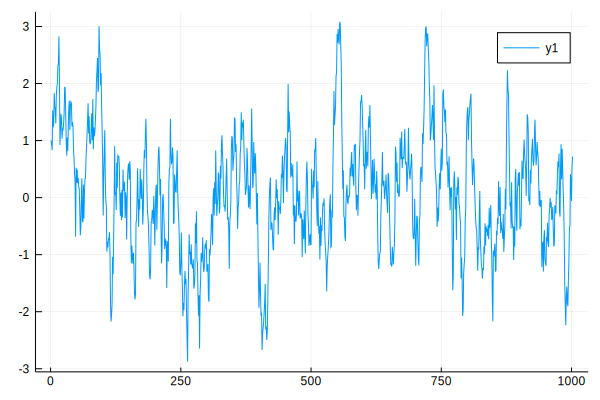

In [38]:
using DifferentialEquations
using Plots

μ = 0.0
σ = sqrt(2)
Θ = 1.0
W = OrnsteinUhlenbeckProcess(Θ,μ,σ,0.0,1.0)
prob = NoiseProblem(W,(0.0,100.0))
sol = solve(prob;dt=0.1)
plot(sol.u)

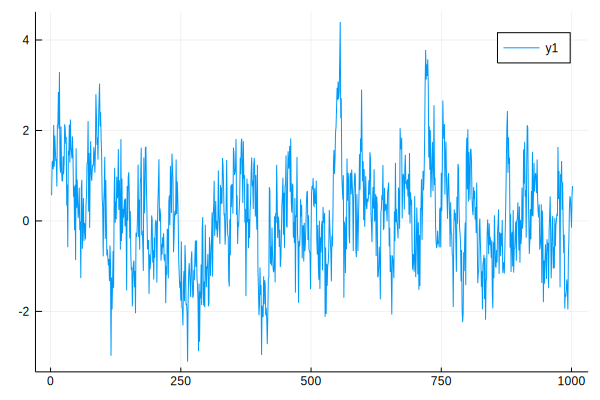

In [76]:
using Distributions, Random
ou_data = sol.u
noise = rand(Normal(0,0.5), length(ou_data))
data = ou_data.+noise
plot(data)

In [40]:
using Polynomials
# function to calculate A and B from the dataset
function OUanalytic(data)
    N = length(data)
    data1sq = data[1]^2
    dataNsq = data[end]^2
    datasq = sum(data[2:end-1].^2)
    datacorr = sum(data[1:end-1].*data[2:end])
    B_coef = Poly([N*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       (2.0-N)*datacorr,     
       (N-1)*datasq])
    B=roots(B_coef)[end-1]
    Q=(data1sq+dataNsq)/(1-B^2)
    Q=Q+datasq*(1+B^2)/(1-B^2)
    Q=Q-datacorr*2*B/(1-B^2)
    A = Q/N
    P2A = -N/A^2/2
    Btmp = B^2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B^4*(N-1))*datasq - 2*B*(1+B^2+2*N)*datacorr
    P2B = -tmp/((1-B^2)^2*(data1sq+dataNsq + (1+B^2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B^2)
    dA = sqrt(-P2B/(P2A*P2B-PAB^2))
    dB = sqrt(-P2A/(P2A*P2B-PAB^2))
    return A,dA,B,dB
end

function OUresult(data,deltat)
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/log(B)
    dtau = deltat*dB/B/log(B)^2
    return A,dA,tau,dtau
end

OUresult (generic function with 1 method)

In [51]:
OUanalytic(ou_data)

(1.027897300069419, 0.14427497400483252, 0.9043889314414983, 0.013407781380854302)

In [53]:
# function to calculate latent variable x from y given sigma,A,B
function latentx(y,sigma,A,B)
    N = length(y)
    x = zeros(N)
    x[1] = y[1]*sigma^2/(sigma^2+A)
    for i=2:N
        x[i] = (y[i]*sigma^2+B*x[i-1]*A*(1-B^2))/(sigma^2+A*(1-B^2))
    end
    return x
end

latentx (generic function with 1 method)

In [84]:
sigma = 0.5
A=1
B=0.9
for i=1:1000
    print("sigma: ",sigma," A: ",A," B: ",B,"\n")
    x = latentx(data,sigma,A,B)
    A,dA,B,dB = OUanalytic(x)
#    sigma = std(data.-x)
end

sigma: 0.5 A: 1 B: 0.9
sigma: 0.5 A: 0.8966935355015475 B: 0.8963430511277786
sigma: 0.5 A: 0.9101423714516909 B: 0.8907246180410883
sigma: 0.5 A: 0.8894108686469849 B: 0.894413453674827
sigma: 0.5 A: 0.9060976313289902 B: 0.8911113958747988
sigma: 0.5 A: 0.8916558192316264 B: 0.893935814627527
sigma: 0.5 A: 0.9040599325534379 B: 0.891515633370356
sigma: 0.5 A: 0.8934290130435414 B: 0.8935979186805556
sigma: 0.5 A: 0.9025690405291862 B: 0.8918141090914152
sigma: 0.5 A: 0.8947335784932621 B: 0.8933481367446607
sigma: 0.5 A: 0.9014676687503586 B: 0.8920332973184933
sigma: 0.5 A: 0.8956926733405286 B: 0.893163498676648
sigma: 0.5 A: 0.9006544204877189 B: 0.8921943899990976
sigma: 0.5 A: 0.896398208785841 B: 0.8930271226286105
sigma: 0.5 A: 0.900054230935525 B: 0.8923128686639318
sigma: 0.5 A: 0.8969174615804948 B: 0.8929264540366633
sigma: 0.5 A: 0.8996114530721765 B: 0.8924000514189543
sigma: 0.5 A: 0.8972997469892087 B: 0.8928521765519186
sigma: 0.5 A: 0.8992848960120725 B: 0.8924642296

sigma: 0.5 A: 0.8983689571007675 B: 0.8926436937080735
sigma: 0.5 A: 0.8983689571007576 B: 0.8926436937080696
sigma: 0.5 A: 0.898368957100772 B: 0.8926436937080738
sigma: 0.5 A: 0.898368957100782 B: 0.8926436937080727
sigma: 0.5 A: 0.898368957100753 B: 0.8926436937080716
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A:

sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5

sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5

sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5

sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5 A: 0.8983689571007766 B: 0.8926436937080725
sigma: 0.5 A: 0.8983689571007648 B: 0.8926436937080726
sigma: 0.5 A: 0.8983689571007794 B: 0.8926436937080727
sigma: 0.5 A: 0.8983689571007848 B: 0.8926436937080753
sigma: 0.5

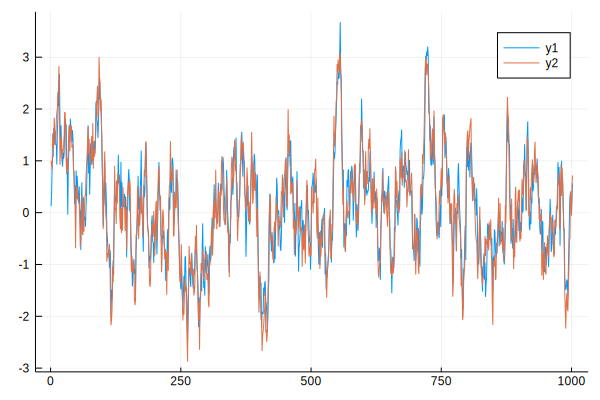

In [85]:
plot(x)
plot!(sol.u)

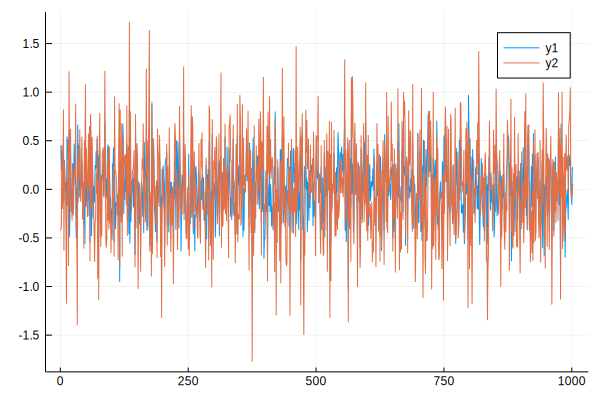

In [86]:
plot(data.-x)
plot!(noise)